### Imports and configuration

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

matplotlib.rc('figure', dpi=125)

### Function to save coupled surge-riverine FIM

In [2]:
# proj crs NAD 1983 UTM Zone 18N
# geographic crs NAD 1983

def couple(surge_fpath, riv_fpath, compound_fpath, alpha, write_tiff, return_array):

    with rio.open(surge_fpath) as ds_in:
        surge_inun = ds_in.read(1, masked=True)
        surge_inun_profile = ds_in.profile
    msk = surge_inun.copy().mask # save mask, will get wiped out on next lines
    surge_inun[surge_inun>3.4e+38] = np.nan # set nodata
    surge_inun[surge_inun < 0] = 0
    surge_inun = np.ma.masked_array(surge_inun, msk)
    # save mask with GDAL convetion for writing later
    # https://rasterio.readthedocs.io/en/latest/topics/masks.html
    w_msk = (~surge_inun.mask * 255).astype('uint8')

    with rio.open(riv_fpath) as ds_in:
        riv_inun = ds_in.read(1, masked=True)
    riv_inun[riv_inun>3.4e+38] = np.nan # set nodata
    riv_inun[riv_inun<0] = 0

    # give riv_inun one extra row and col to match shapes with surge_inun
    # this is due to how ArcGIS projected raster
    # extra row and col will get masked out when written to .tif
    newrow = np.empty(riv_inun.shape[1])
    newrow.fill(np.nan)
    riv_inun = np.vstack([riv_inun,newrow])

    newcol = np.empty([riv_inun.shape[0],1])
    newcol.fill(np.nan)
    riv_inun = np.hstack([riv_inun,newcol])

    # avoid divide by zero errors
    ratio_adj = 0.001 # 0.001 m = 0.04 in
    ratio_array = (surge_inun + ratio_adj) / (riv_inun + ratio_adj)

    # vary alpha (see eqn. 2 from SI 2022 paper)
    # calculate compound inundation accounting for transition zone
    # implement eqn. 2 from SI 2022 paper
    compound_inun = np.where(
        ratio_array > 1, # coastal zone
        surge_inun,
        np.where(
            ratio_array <= alpha*riv_inun, # hydrologic zone
            riv_inun,
            np.where(
                (ratio_array <= 1 & (ratio_array > alpha*riv_inun)), # transition zone
                ratio_array*np.maximum(surge_inun, riv_inun) + (1 - ratio_array)*(surge_inun + riv_inun),
                np.nan, # else assign NaN
        )))

    if write_tiff:
        # write raster with internal mask (no .msk sidecar)
        with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
            with rio.open(compound_fpath, 'w', **surge_inun_profile) as ds_out:
                ds_out.write(compound_inun,1)
                ds_out.write_mask(w_msk)

    if return_array:
        return np.ma.masked_array(compound_inun,msk)

### Run function and view result

In [3]:
# make compound inundation map

florence_SEP14 = couple(
    surge_fpath = 'data_github/florence_surge_nhc_max.tif',
    riv_fpath = 'data_github/030202_201809140600_depth_map_projUTM18n.tif',
    compound_fpath = 'data_github/compound_inun_SEP14_alpha1.tif',
    alpha = 1, # see eqn. 2 in SI 2022 paper
    write_tiff = True,
    return_array = True
)

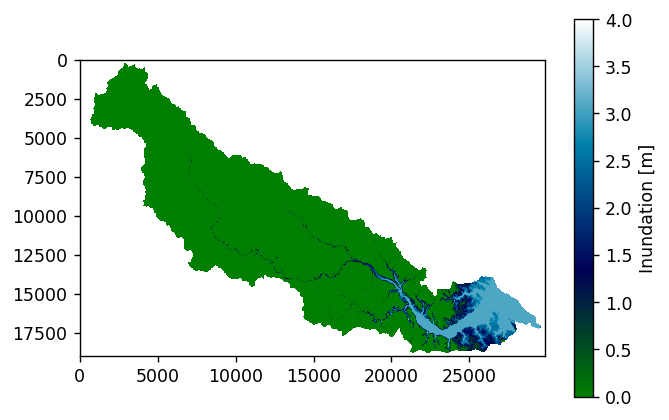

In [4]:
plt.close('all')

fig, ax = plt.subplots()

cbar = ax.imshow(
    florence_SEP14,
    vmin=0,
    vmax=4,
    cmap=plt.get_cmap('ocean')
    )

fig.colorbar(cbar,label='Inundation [m]',ax=ax)